In [2761]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox

import warnings
warnings.filterwarnings('ignore')

In [2762]:
home_dir = '/home/jupyter/data_science_projects/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

In [2763]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

#df = df.loc[df.Country == 'United Kingdom']

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

### Convenience Functions

In [2764]:
def transform_and_scale(data, reverse_field=None):
    """
    Purpose: Transform data using Boxcox and StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox and StandardScaler...')
    if reverse_field:
        print(f'With Reverse Field(s): {reverse_field}')
    #print(data.head())
    if not isinstance(data,pd.core.frame.DataFrame):
        data = data.to_frame()
    for c in data.columns:
        print(f"Transforming {c}...")
        v,l = boxcox(abs(data[c]+.0000000001))
        data[c] = v
        
        print(f"Scaling {c}...")
        scaler = MinMaxScaler()
        data[c] = scaler.fit_transform(np.array(data[c].to_frame()))
        
        if reverse_field:
            print(f"Reversing {c}...")
            data[c] = 1 - data[c] 
           
    #print(data.head())
    return data

def plot_cluster_graph(data, transform_and_scale_data=True):
    
    """
    Purpose: Plot cluster graph
    Input: 
        data - a dataframe column
        transform_and_scale - boolean.  Default is True.  If False, data is not transformed via boxcox transform or scaled via StandardScaler
    Output: A scree plot that allows us to determine optimal number of clusters
    """

    
    print('Plotting cluster graph...')
    
    #Sum of Sqared Errors
    sse = {}

    if transform_and_scale_data:
        #Scales and Transforms data
        data = transform_and_scale(data)

    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(data)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 5))
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
def plot_cluster_scatter(data, cols, label, n, transform_and_scale_data=True, algorithm='PCA'): 
    
    plt.figure(figsize=(10, 5))
    
    if transform_and_scale_data:
        #Scales and Transforms data
        data[cols] = transform_and_scale(data[cols])
    
    if algorithm.lower() == 'pca':
    
        from sklearn.decomposition import PCA
    
        pca = PCA(n_components=n)
    
        results = pd.DataFrame(pca.fit_transform(data[cols]))

        results.columns = [f'PC{i+1}' for i in range(n)]

        data['PC1'] = results['PC1']

        data['PC2'] = results['PC2']
        
        sns.scatterplot(x='PC1',y='PC2', hue=label, palette=sns.color_palette("hls",10),data=data)
        
    if re.sub('-', '', algorithm.lower()) == 'tsne':
        
        from sklearn.manifold import TSNE
        
        tSNE=TSNE(n_components=n)
        
        tSNE_result=tSNE.fit_transform(data)
        
        data['X'] = tSNE_result[:,0]

        data['Y'] = tSNE_result[:,1]
    
        sns.scatterplot(x='X',y='Y', hue=label, palette=sns.color_palette("hls",10),data=data)

def assign_cluster(data, n_clusters, reverse_field=None):
    """
    Purpose: Assign cluster
    Input: 
        data - a dataframe column
        n_clusters - number of clusters
        reverse_field - list or string for columns to reverse
    Output:
        an array with a new column called Cluster
        """
    
    #Scales and Transforms data
    data = transform_and_scale(data, reverse_field=reverse_field)
    
    print('Assigning cluster...')
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, n_init='auto')
    
    # Predicts Cluster
    data['clusters'] = kmeans.fit_predict(data) + 1
    
    return data['clusters']

def rerank_clusters(data, data_col, cluster_col, reverse_field=None):
    """
    Purpose: Rerank clusters
    Input:
        data - a dataframe 
        data_col - a column name for the column representing the data
        cluster_col - a column name for the column representing a cluster to rerank
            
    Output:
        data - a dataframe 
    
    """
    
    if isinstance(data_col, list):
        data['new_data_col'] = np.sum(data[data_col], axis=1)
        data_col = 'new_data_col'
          
    tdf = data.groupby(cluster_col, as_index=False)\
    .agg(NewCluster = (data_col, 'mean'))\
    .rank(method="dense")
    
    if reverse_field:
        print(f'Reversing {reverse_field} clusters...')
        tdf.sort_values('NewCluster', ascending=False, inplace=True)
        l = tdf['NewCluster'].to_list()
        l.reverse()
        tdf['NewCluster'] = l
    
    data = data.merge(tdf
      , on=cluster_col, how='inner')\
      .rename(columns={cluster_col:"drop_column"})\
      .rename(columns={'NewCluster':cluster_col})\
      .drop('drop_column', axis=1)\

    if isinstance(data_col, list):
        data.drop(columns='new_data_col', axis=1, inplace=True)
        
    return data

def generate_cluster_df(df, n_clusters,col=None, reverse_field=None):
    """
    Purpose: Generate cluster data
    Input: 
        df - a dataframe column
        n_clusters - number of clusters
        col - a column name
        reverse_field - list or string for columns to reverse
    Output: 
        a dataframe with a new column called Cluster
        """
    #print(df.head())
    #print(reverse_field)
    if isinstance(col, str):
        output_col_name = f'{col}Cluster'
        
    elif isinstance(col, list):
        output_col_name = 'FinalCluster'
    
    df[output_col_name] = assign_cluster(df[col], n_clusters,reverse_field=reverse_field)
    
    df = rerank_clusters(df, cluster_col = output_col_name, data_col=col, reverse_field=reverse_field)
    #print(df.head())
    return df

def analyze_clusters(df,col, n_clusters:int, reverse_field=None):
    """
    Purpose: Analyze clusters
    Input: 
        df - a dataframe column
        col - a column name
        n_clusters - number of clusters
        reverse_field - column name or list of column names. If reverse_field is not None, reverses the fieldeven without "reverse" being true.
        
    Output: 
        a dataframe with a new column called Cluster
        """
    if reverse_field and not isinstance(reverse_field, list):
        reverse_field = [reverse_field]

    df =  generate_cluster_df(df=df, n_clusters=n_clusters, col=col, reverse_field=reverse_field)
    
    return df


### RECENCY, FREQUENCY, MONETARY ANALYSIS 
Objective is to find the RFM for each customer to determing Low, Medium and High Value Customers

In [2765]:
#new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()

#### Recency

In [2766]:
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Recency...
Scaling Recency...


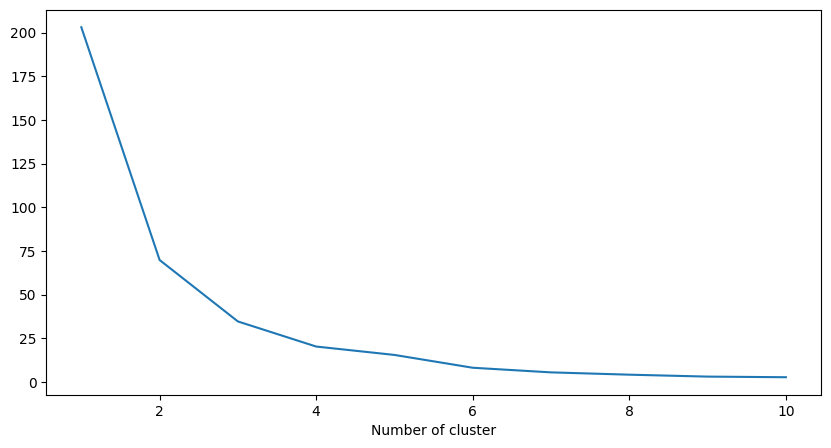

In [2767]:
r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'max'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)

#r_df.Recency.describe()
plot_cluster_graph(r_df['Recency'])

Scree plot shows 3 or 4 clusters would be optimal

In [2768]:
r_df = analyze_clusters(r_df, n_clusters=4,col ='Recency',reverse_field='Recency')
r_df.groupby('RecencyCluster')['Recency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency']
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency'] clusters...


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1.0,1124.0,242.113879,68.717947,134.0,183.00,238.0,296.0,373.0
2.0,1324.0,72.783988,25.717228,38.0,51.75,67.0,89.0,133.0
3.0,1427.0,19.367204,8.868827,6.0,11.00,18.0,27.0,37.0
4.0,464.0,2.066810,1.482022,0.0,1.00,2.0,3.0,5.0


#### Frequency
We are going to use the formula:
Frequency = 1 / Median( Time between Purchases)

In [2769]:
f_df = new_df[['InvoiceDate','CustomerID']].drop_duplicates().sort_values(by=['CustomerID','InvoiceDate'], ascending=True).reset_index(drop=True)

#Creating difference between invoice dates per person
f_df['Offset'] = f_df.groupby(['CustomerID'])['InvoiceDate'].diff().dt.seconds

# Creating Count per user
f_df = f_df.merge(\
    f_df.groupby(['CustomerID']).agg(Count = ('InvoiceDate', 'count')).reset_index()\
           ,on=['CustomerID'], how='inner')

# Finding folks who only had one interaction and giving them an Offset that is differenced from the latest day in the dataset
f_df.loc[f_df.Count == 1, 'Offset'] = (f_df.InvoiceDate.max() - f_df.InvoiceDate).dt.seconds

# Dropping the first occurance of a invoicedate.  Not needed to make agg.
f_df = f_df.loc[~(f_df.Offset.isna())]

f_df = f_df.groupby(['CustomerID']).agg(Frequency = ('Offset','median')).reset_index()

#f_df['FrequencyHertz'] = 1/f_df.Frequency

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Frequency...
Scaling Frequency...


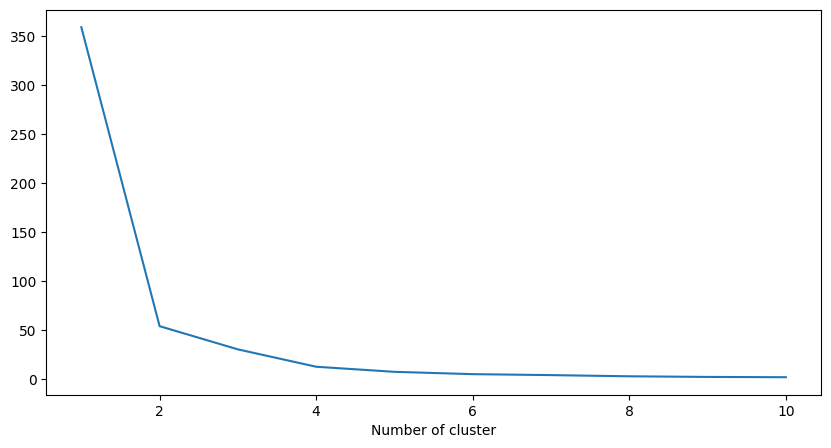

In [2770]:
plot_cluster_graph(f_df['Frequency'])

In [2771]:
f_df = analyze_clusters(f_df, 'Frequency', 4, reverse_field='Frequency')
f_df.groupby('FrequencyCluster')['Frequency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Frequency']
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Assigning cluster...
Reversing ['Frequency'] clusters...


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1.0,1766.0,77443.522084,5984.954758,58740.0,73515.0,78420.0,82320.0,86340.0
2.0,651.0,41655.391705,6218.073753,23340.0,39795.0,42480.0,45165.0,57300.0
3.0,1205.0,11571.834025,4375.915362,5460.0,7920.0,10740.0,14100.0,23280.0
4.0,717.0,2451.882845,1639.460821,0.0,900.0,2400.0,3840.0,5430.0


#### Monetary

In [2772]:
m_df = new_df[['CustomerID','Revenue']].groupby('CustomerID').agg(Revenue = ('Revenue', 'sum')).reset_index()

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...


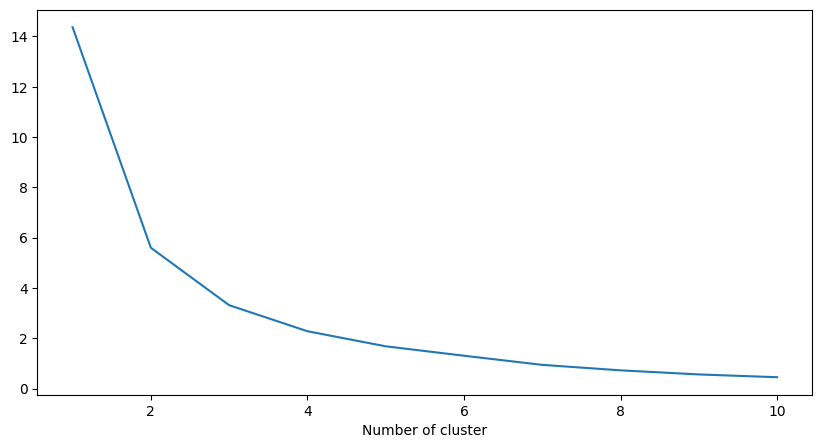

In [2773]:
plot_cluster_graph(m_df['Revenue'])

In [2774]:
m_df = analyze_clusters(m_df, 'Revenue', 4)
m_df.groupby('RevenueCluster')#['Revenue'].describe()

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Assigning cluster...


In [2775]:
final_df = m_df.merge(r_df, on='CustomerID', how='inner').merge(f_df, on='CustomerID', how='inner')

final_df = final_df[['CustomerID','Recency','Frequency','Revenue','RecencyCluster','FrequencyCluster','RevenueCluster']]

Plotting cluster graph...
Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


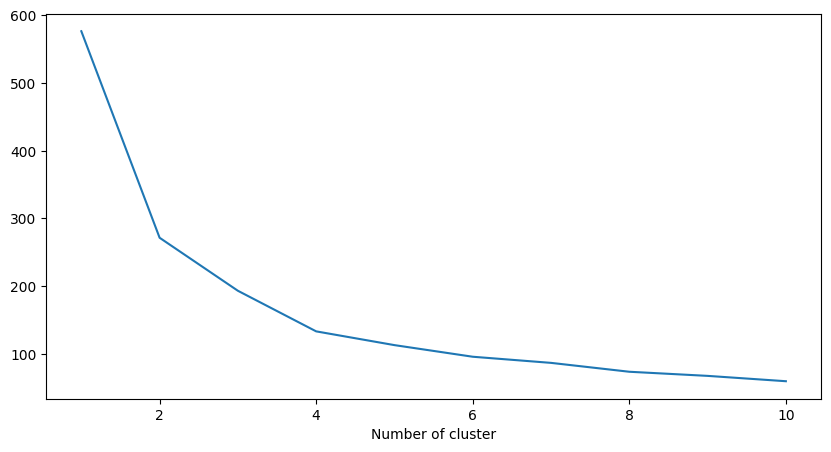

In [2776]:
plot_cluster_graph(final_df[['Revenue', 'Frequency', 'Recency']])

In [2807]:
rfm = analyze_clusters(final_df, ['Revenue', 'Frequency', 'Recency'], 4, reverse_field=['Recency', 'Frequency'])
#rfm2=analyze_clusters(final_df, ['Revenue', 'Frequency', 'Recency'], 4)

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency', 'Frequency']
Transforming Revenue...
Scaling Revenue...
Reversing Revenue...
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency', 'Frequency'] clusters...


In [2810]:
rfm.head()

,CustomerID,Recency,Frequency,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster,new_data_col,FinalCluster
0,12346.0,325,10140.0,77183.60,1.0,3.0,4.0,87648.60,4.0
1,12435.0,79,5160.0,7829.89,2.0,4.0,4.0,13068.89,4.0
2,12590.0,210,360.0,9864.26,1.0,4.0,4.0,10434.26,4.0
3,12637.0,66,6150.0,6002.90,2.0,3.0,4.0,12218.90,4.0
4,12688.0,113,14460.0,4873.81,2.0,3.0,4.0,19446.81,4.0


## Plotting Clusters

### Final Clusters

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


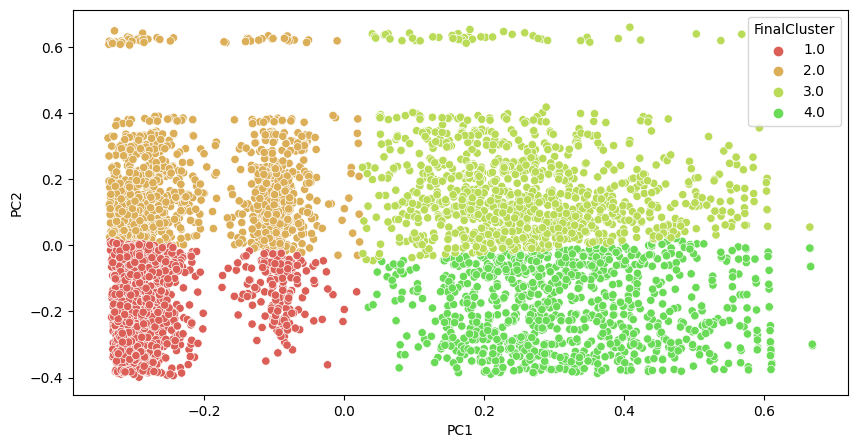

In [2809]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FinalCluster', n=3, transform_and_scale_data=True, algorithm='pca')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


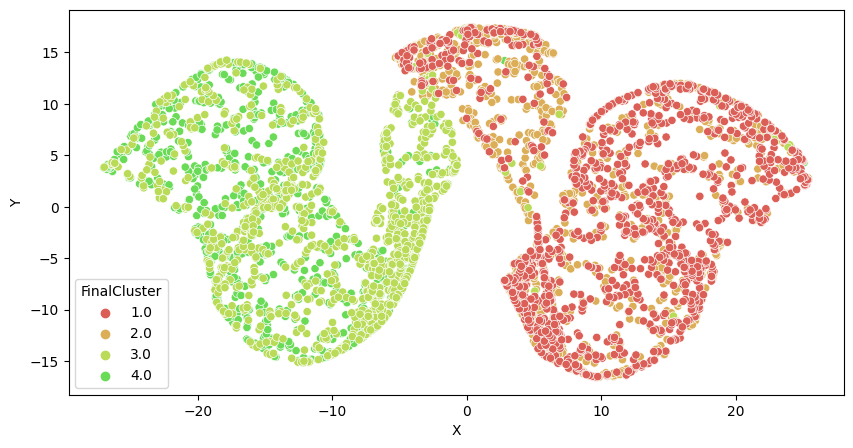

In [2781]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FinalCluster', n=3, transform_and_scale_data=True, algorithm='tsne')

### Recency

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


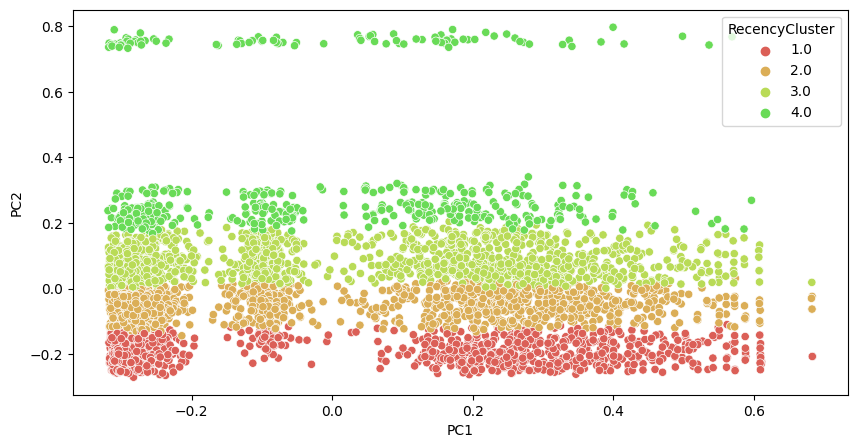

In [2782]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RecencyCluster', n=3, transform_and_scale_data=True, algorithm='PCA')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


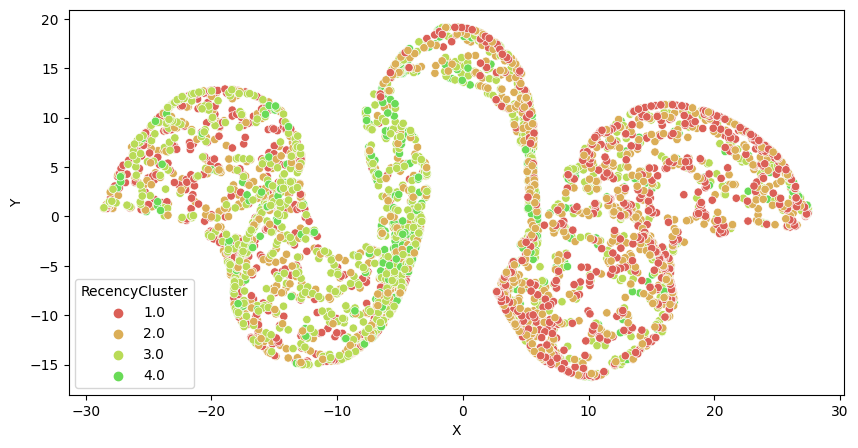

In [2783]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RecencyCluster', n=3, transform_and_scale_data=True, algorithm='tsne')

### Frequency

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


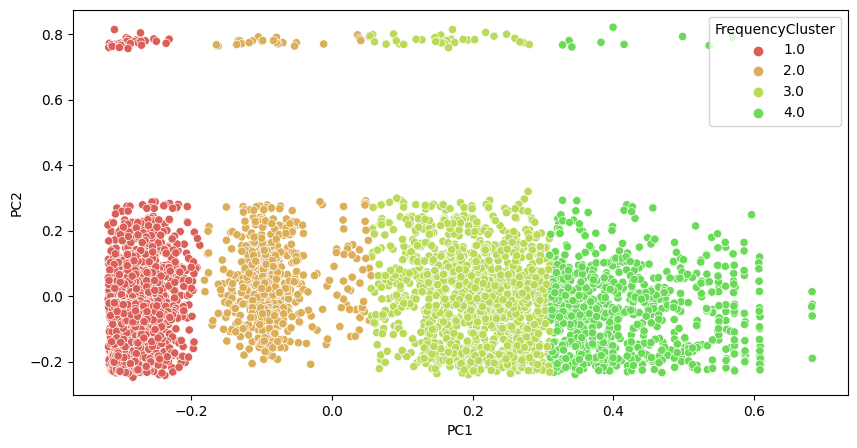

In [2784]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FrequencyCluster', n=3, transform_and_scale_data=True, algorithm='PCA')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


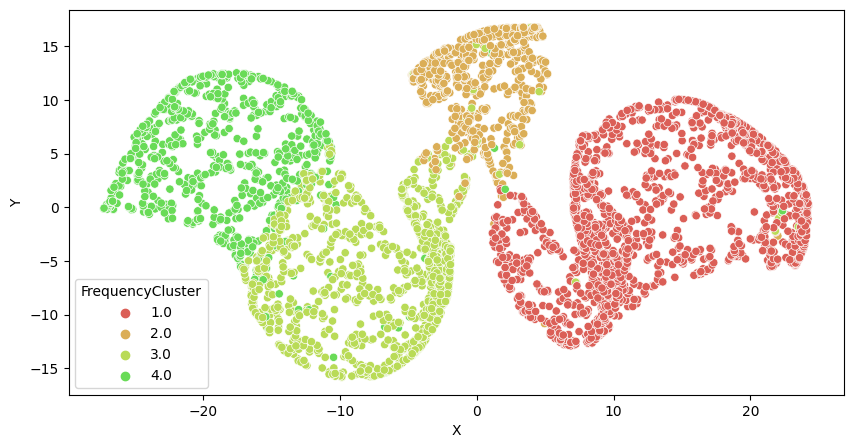

In [2785]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='FrequencyCluster', n=3, transform_and_scale_data=True, algorithm='tsne')

### Revenue

#### PCA

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


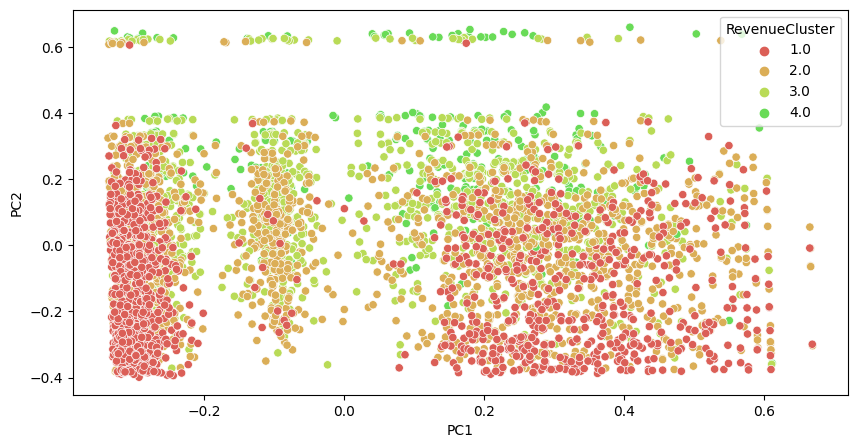

In [2800]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RevenueCluster', n=3, transform_and_scale_data=True, algorithm='pca')

#### TSNE

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Transforming Frequency...
Scaling Frequency...
Transforming Recency...
Scaling Recency...


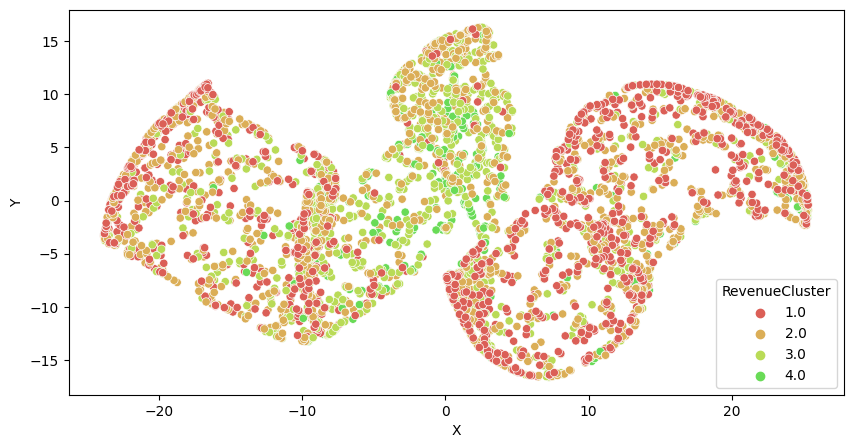

In [2787]:
plot_cluster_scatter(data=rfm.copy(), cols=['Revenue', 'Frequency', 'Recency'], label='RevenueCluster', n=3, transform_and_scale_data=True, algorithm='tsne')

In [2788]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2811]:
rfm.groupby(['FinalCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
FinalCluster,,,,,,,,
1.0,1184.0,157.909628,93.030210,44.0,74.0,134.0,224.25,372.0
2.0,1196.0,19.299331,14.146243,0.0,8.0,17.0,29.00,63.0
3.0,1026.0,20.232943,16.025995,0.0,7.0,17.0,31.00,72.0
4.0,933.0,178.233655,98.057885,45.0,86.0,161.0,262.00,373.0


In [2812]:
rfm.groupby(['FinalCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FinalCluster,,,,,,,,
1.0,1184.0,73244.189189,13528.193472,28440.0,71385.0,77835.0,82260.0,86340.0
2.0,1196.0,63740.819398,17324.891914,27540.0,44430.0,71040.0,78757.5,86340.0
3.0,1026.0,9729.298246,6379.242641,0.0,4687.5,8835.0,13800.0,27300.0
4.0,933.0,7124.951768,5458.004037,0.0,2640.0,6360.0,10680.0,26580.0


In [2813]:
rfm.groupby(['FinalCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
FinalCluster,,,,,,,,
1.0,1184.0,698.412907,866.636190,6.90,211.6575,409.485,854.96,11072.67
2.0,1196.0,2306.050970,7079.108572,0.00,540.8450,1105.830,2339.16,168472.50
3.0,1026.0,4361.171931,16233.269135,30.00,500.5725,1356.870,3406.46,280206.02
4.0,933.0,887.126100,3321.840823,3.75,207.8000,390.540,765.32,77183.60


In [2814]:
rfm.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
1.0,1170.0,187.517650,77.810272,0.00,125.970,183.73,251.4425,319.02
2.0,1678.0,637.569811,231.259221,319.50,429.570,604.13,808.2225,1134.28
3.0,1191.0,2251.718926,911.609229,1135.04,1493.845,2000.86,2801.9800,4668.30
4.0,300.0,16387.246200,30598.375284,4684.76,5676.360,7364.76,12462.5400,280206.02


In [2815]:
rfm.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1.0,1766.0,77443.522084,5984.954758,58740.0,73515.0,78420.0,82320.0,86340.0
2.0,651.0,41655.391705,6218.073753,23340.0,39795.0,42480.0,45165.0,57300.0
3.0,1205.0,11571.834025,4375.915362,5460.0,7920.0,10740.0,14100.0,23280.0
4.0,717.0,2451.882845,1639.460821,0.0,900.0,2400.0,3840.0,5430.0


In [2816]:
rfm.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1.0,1124.0,242.113879,68.717947,134.0,183.00,238.0,296.0,373.0
2.0,1324.0,72.783988,25.717228,38.0,51.75,67.0,89.0,133.0
3.0,1427.0,19.367204,8.868827,6.0,11.00,18.0,27.0,37.0
4.0,464.0,2.066810,1.482022,0.0,1.00,2.0,3.0,5.0
